## Auto Camera_손동작 인식

In [ ]:
import torch
import yaml
from glob import glob
import random
from IPython.display import Image, display
from IPython.core.magic import register_line_cell_magic

In [ ]:
%cd /content
%pwd

/content


'/content'

### YOLOv5 git clone

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16575, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 16575 (delta 28), reused 37 (delta 18), pack-reused 16522
Receiving objects: 100% (16575/16575), 15.09 MiB | 26.27 MiB/s, done.
Resolving deltas: 100% (11381/11381), done.


In [ ]:
%cd yolov5

/content/yolov5


### Dataset Download

In [ ]:
%mkdir /content/yolov5/handsign
%cd /content/yolov5/handsign

/content/yolov5/handsign


In [ ]:
!curl -L "https://universe.roboflow.com/ds/pjDmLDayNm?key=AJj1tUDUCQ" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: train/images/33cc8f19-c5bf-4887-97a1-7d445654b21d-rgb_0000_png_jpg.rf.6df2c9571aabc3d06b3bca7af0e89be9.jpg  
 extracting: train/images/33cc8f19-c5bf-4887-97a1-7d445654b21d-rgb_0000_png_jpg.rf.f635cf432336003e5c64564572c34f69.jpg  
 extracting: train/images/33f0c209-9467-48d3-9758-2d5ee8a3c5c5-rgb_0000_png_jpg.rf.8dc0e164a2f3d7adc3fbad6c8635958f.jpg  
 extracting: train/images/33f0c209-9467-48d3-9758-2d5ee8a3c5c5-rgb_0000_png_jpg.rf.c9602001275d129494a436949e6e0977.jpg  
 extracting: train/images/342db99b-ebc5-4446-af6d-8820885068a1-rgb_0000_png_jpg.rf.34ce54bfc9299cb760052177cf9a12d9.jpg  
 extracting: train/images/342db99b-ebc5-4446-af6d-8820885068a1-rgb_0000_png_jpg.rf.f1aa1a7f3308ec07cd3737264b255552.jpg  
 extracting: train/images/3514406a-be2d-4ef2-ac18-684474227eb2-rgb_0000_png_jpg.rf.1badc4abaaf5613d735fdc8cccc40c2d.jpg  
 extracting: train/images/3514406a-be2d-4ef2-ac18-684474227eb2-rgb_0000_png_jpg.rf.757acb7465242e28620c89ec6f6

## 데이터셋 전처리 + data.yaml 지정

In [ ]:
train_img_list = glob('/content/yolov5/handsign/train/images/*.jpg')
test_img_list = glob('/content/yolov5/handsign/test/images/*.jpg')
valid_img_list = glob('/content/yolov5/handsign/valid/images/*.jpg')
print(len(train_img_list), len(test_img_list), len(valid_img_list))

2664 72 76


In [ ]:
with open('/content/yolov5/handsign/train.txt','w') as f:
    f.write('\n'.join(train_img_list) + '\n')
with open('/content/yolov5/handsign/test.txt','w') as f:
    f.write('\n'.join(test_img_list) + '\n')
with open('/content/yolov5/handsign/val.txt','w') as f:
    f.write('\n'.join(valid_img_list) + '\n')

In [ ]:
@register_line_cell_magic
def writetemplate(line,cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/handsign/data.yaml

train: ./handsign/train/images
test: ./handsign/test/images
val: ./handsign/valid/images

nc: 1
names: ['Peace']

In [ ]:
%cat /content/yolov5/handsign/data.yaml


train: ./handsign/train/images
test: ./handsign/test/images
val: ./handsign/valid/images

nc: 1
names: ['Peace']


In [ ]:
with open('/content/yolov5/handsign/data.yaml','r') as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])

%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# Parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%cat /content/yolov5/models/custom_yolov5s.yaml


# Parameters
nc: 1  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, Fa

## Fine-tuning

In [ ]:
%%time
%cd /content/yolov5

/content/yolov5
CPU times: user 1.05 ms, sys: 10 µs, total: 1.06 ms
Wall time: 1.02 ms


In [ ]:
%rm /content/yolov5/handsign/train/labels.cache

rm: cannot remove '/content/yolov5/handsign/train/labels.cache': No such file or directory


In [ ]:
!python /content/yolov5/train.py --img 640 --batch 32 --epochs 100 --data /content/yolov5/handsign/data.yaml --cfg /content/yolov5/models/custom_yolov5s.yaml --weights '' --name handsign_result --cache disk

2024-05-02 05:02:41.777689: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 05:02:41.777746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 05:02:41.779622: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=, cfg=/content/yolov5/models/custom_yolov5s.yaml, data=/content/yolov5/handsign/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=disk, image_weights=

### 학습 결과 확인

In [ ]:
!ls /content/yolov5/runs/train/handsign_result/

confusion_matrix.png				    P_curve.png       train_batch2.jpg
events.out.tfevents.1714626163.913eb1a28666.2881.0  PR_curve.png      val_batch0_labels.jpg
F1_curve.png					    R_curve.png       val_batch0_pred.jpg
hyp.yaml					    results.csv       val_batch1_labels.jpg
labels_correlogram.jpg				    results.png       val_batch1_pred.jpg
labels.jpg					    train_batch0.jpg  weights
opt.yaml					    train_batch1.jpg


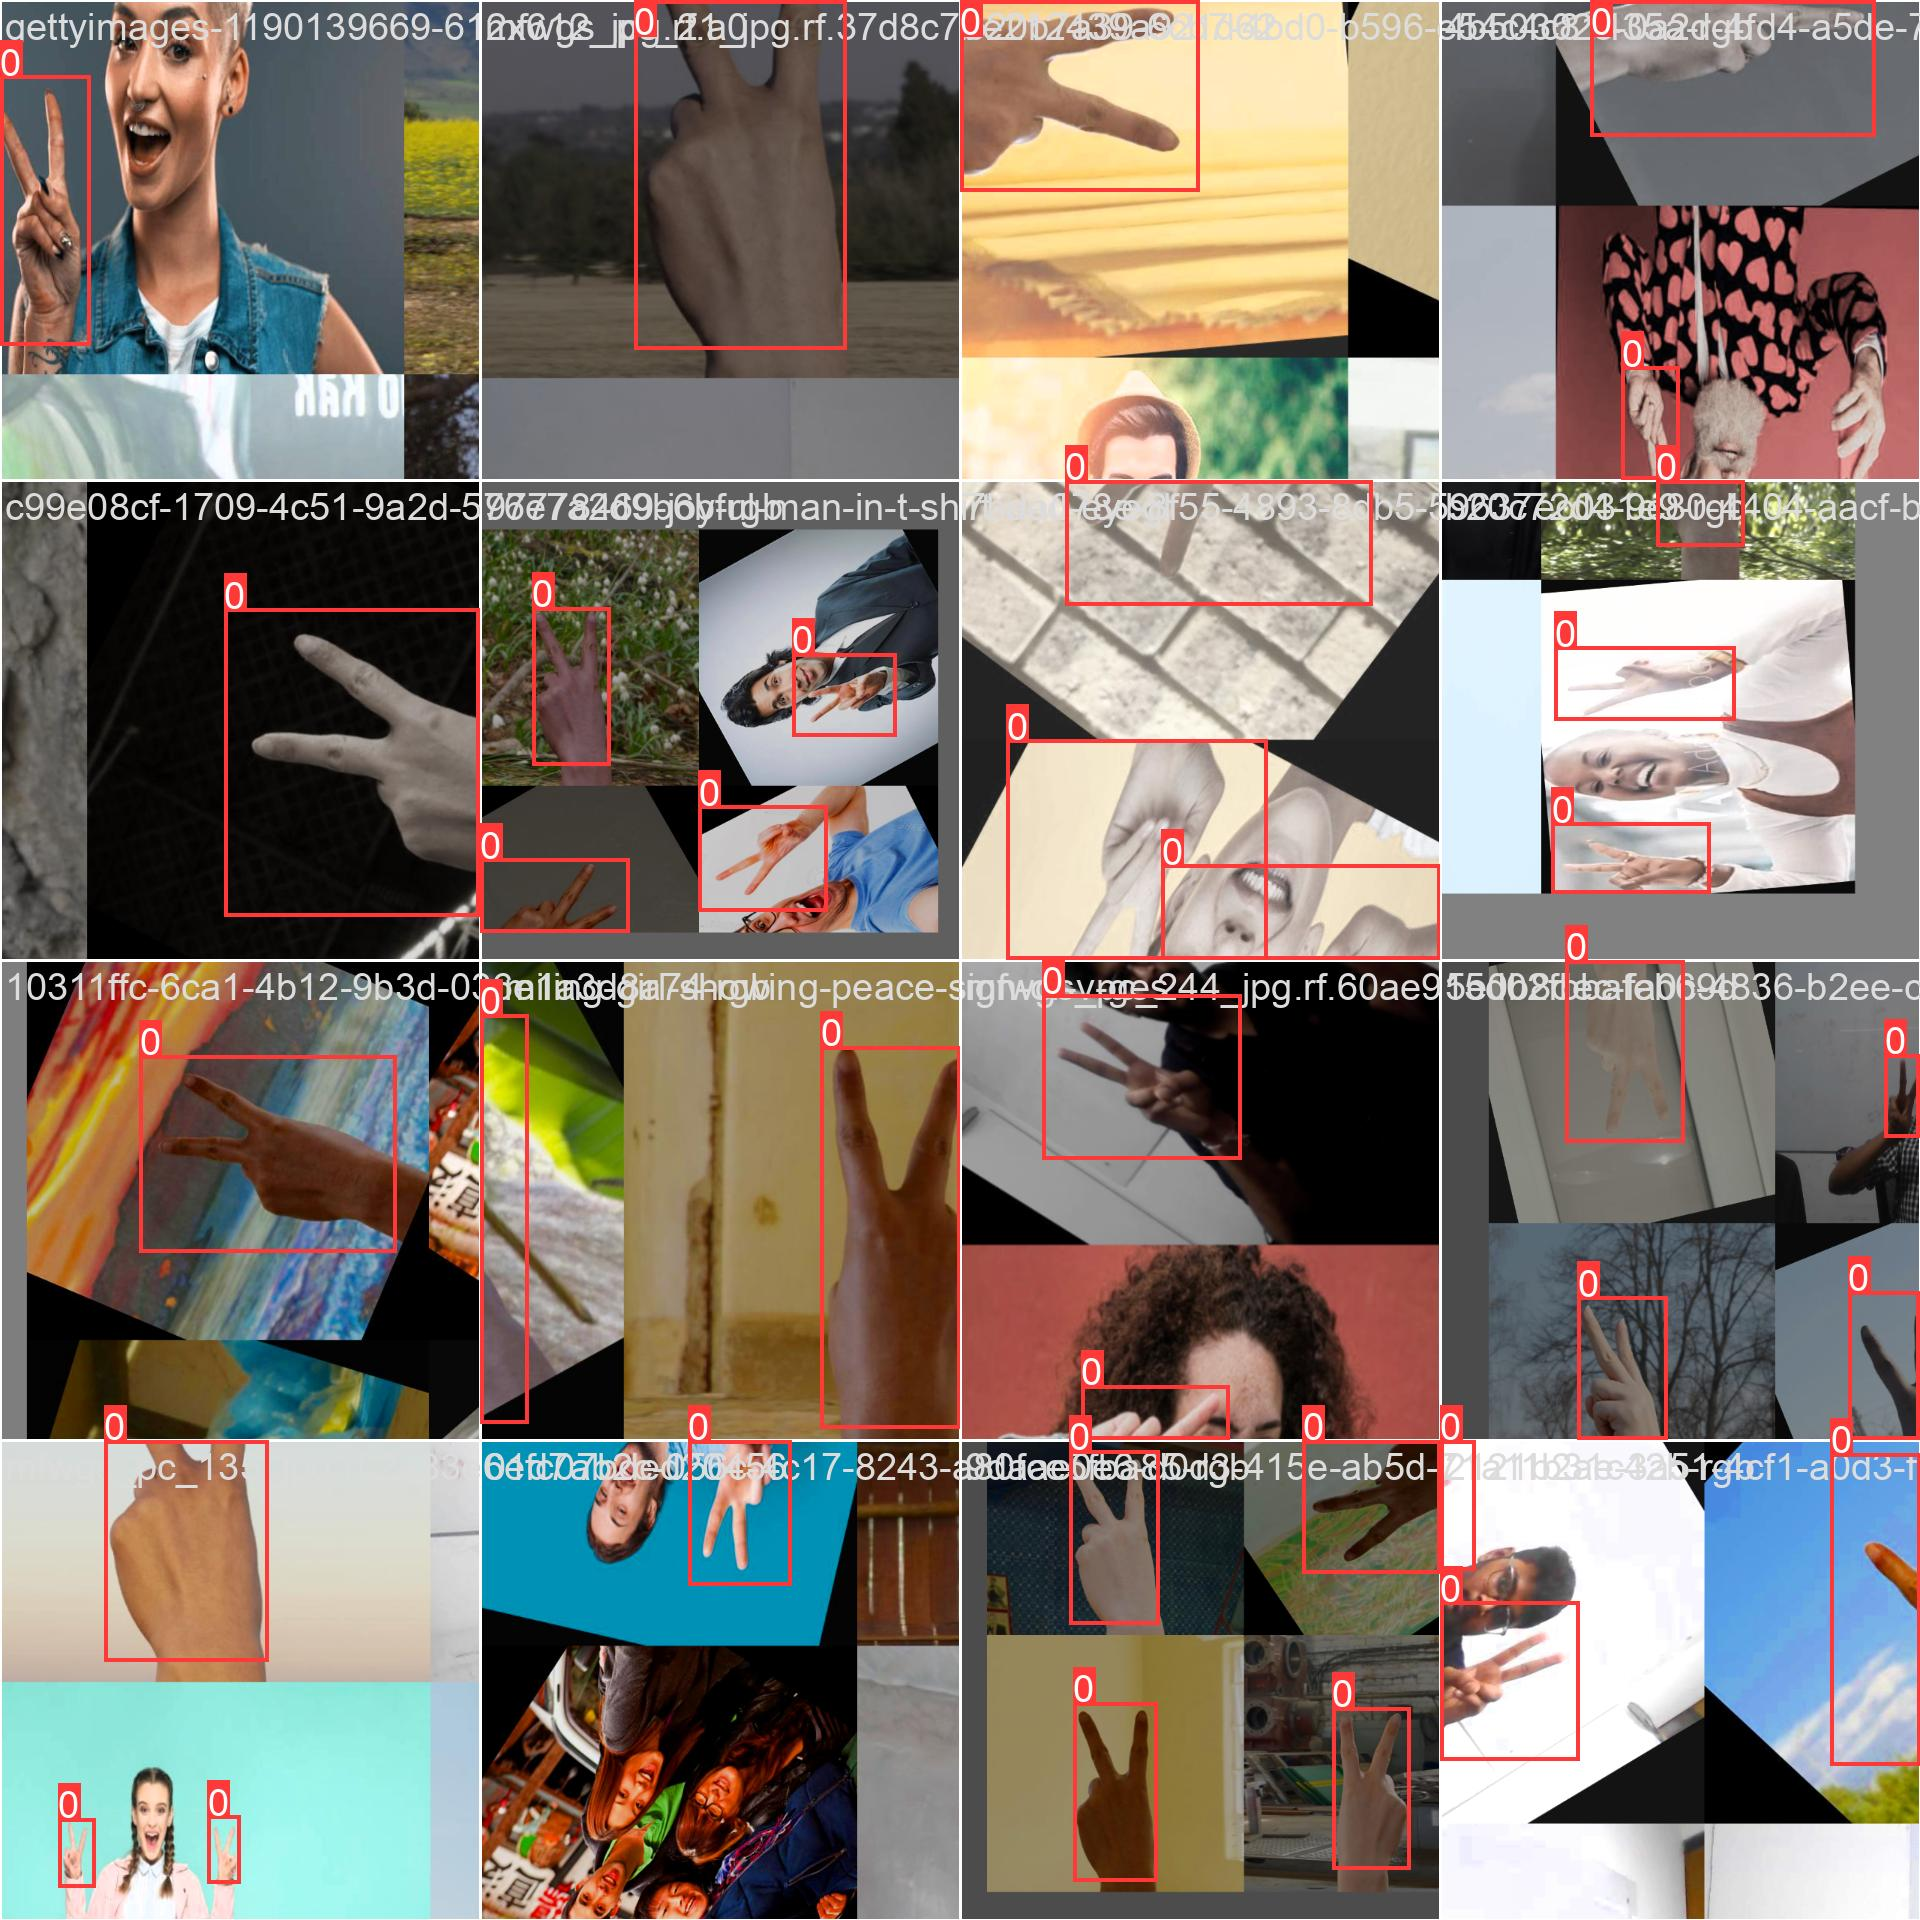

In [ ]:
Image(filename='/content/yolov5/runs/train/handsign_result/train_batch0.jpg', width=1500)

In [ ]:
%ls /content/yolov5/runs/train/handsign_result/weights

best.pt  last.pt


In [ ]:
!python detect.py --weights /content/yolov5/runs/train/handsign_result/weights/best.pt --img 640 --conf 0.4 --source ./handsign/test/images

detect: weights=['/content/yolov5/runs/train/handsign_result/weights/best.pt'], source=./handsign/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-306-gb599ae42 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/72 /content/yolov5/handsign/test/images/08ad850e-cd31-42e2-9c9e-b5b9fd3cf029-rgb_0000_png_jpg.rf.db939dc2a39e82fb606e197196f8f11c.jpg: 640x640 1 Peace, 11.5ms
image 2/72 /content/yolov5/handsign/test/images/1200px-Iraqi_boys_giving_peace_sign_jpg.rf.4ab0c3e4434ae7a39f1eae9ef5a13946

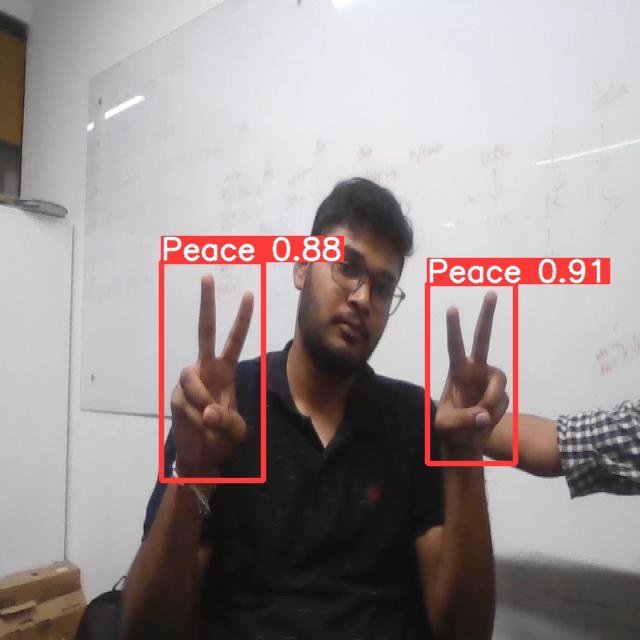

In [ ]:
import glob

image_name = random.choice(glob.glob('/content/yolov5/runs/detect/exp2/*.jpg'))

display(Image(filename=image_name))